### Notes

**Path**: `/Users/olga_golubova/Desktop/new data.xlsx`  
**Number of Subjects**: 8

**Data Source**:
- **Raw Data**: Located in the tab "raw data". 
  - Column A1:A45 contains data for subject 1, B1:B45 for subject 2, and so on.
- **Actual Coordinates**: Located in the tab "actual".
  - For each subject, the first 10 rows in a column represent x coordinates, and the next 10 rows represent y coordinates.
  - Example: 
    - Subject 1: x coordinates from A1:A10, y coordinates from A11:A20.
    - Subject 2: x coordinates from B1:B10, y coordinates from B11:B20.
    
These coordinates are all same, and are taken from a random participant. I will need to get average male and average female person from the past study (MDS body) and re-run. This is just to check data is ok for further collection.

**Procedure**:
1. **Extract Actual Coordinates**:
   For each subject, extract x and y coordinates for the actual map from the "actual" tab.

2. **Convert Raw Data to Squareform**:
   For each subject, convert the raw data into a squareform distance matrix.

3. **Multidimensional Scaling (MDS)**:
   Obtain coordinates and eigenvalues from the squareform matrices using MDS.

4. **Variance Explained by Dimensions**:
   Use the eigenvalues for all 10 dimensions to calculate the variance explained by each dimension.
   Visualize the variance explained in a scree plot.

5. **Procrustes Alignment**:
   Perform Procrustes alignment between actual shapes and perceived shapes for each subject.

6. **Generalized Procrustes Analysis (GPA)**:
   Perform GPA for the actual shapes.
   Perform GPA for the perceived shapes.

**Visualization**:
1. **Comparison of Actual and Perceived Shapes for Each Subject**:
   Visualize the comparison in a 4 by 2 grid (4 rows and 2 columns) for easier visualization, given there are 8 subjects (at the moment).
   Shapes should match as closely as possible, adjusting for rotation, scale, and position.

2. **Mean Generalized Procrustes Alignment**:
   Create a figure showing the mean GPA for actual and perceived shapes.
   This figure should display the mean location of landmarks for each subject compared to the mean actual location of the landmarks.

**Additional Notes**:

- The code will be using 2D visualisation and analysis, but I am using 3D for now to check the data.

**To do list**:

- Simulations
- Stat tests
- Male and female
- SESS questionnaire and analysis

## 2D Analysis and Visualization

In [4]:
import pandas as pd  # Importing pandas for data manipulation
import numpy as np  # Importing numpy for numerical operations
from scipy.spatial.distance import squareform  # Importing squareform to convert distance vectors to matrices
from sklearn.manifold import MDS  # Importing MDS for multidimensional scaling
from scipy.spatial import procrustes  # Importing procrustes for shape alignment
from scipy.linalg import orthogonal_procrustes  # Importing orthogonal_procrustes for Procrustes analysis
import matplotlib.pyplot as plt  # Importing matplotlib for plotting

Path to the Excel file

In [5]:
file_path = '/Users/olga_golubova/Desktop/new data.xlsx'
num_subjects = 8  # Number of subjects

Reading the data from Excel

In [6]:
raw_data = pd.read_excel(file_path, sheet_name='raw data', header=None)  # Raw data
actual_data = pd.read_excel(file_path, sheet_name='actual', header=None)  # Actual coordinates data

Extracting x, y coordinates for each subject and storing them in a dictionary

In [7]:
actual_coords = {
    f'subject_{i+1}': np.column_stack((actual_data.iloc[:10, i].values, actual_data.iloc[10:20, i].values)) 
    for i in range(num_subjects)
}

Function to convert raw data to squareform matrix

In [8]:
def raw_to_squareform(raw_column):
    return squareform(raw_column)

Function to perform multidimensional scaling

In [9]:
def mds_coordinates(squareform_matrix):
    mds = MDS(dissimilarity='precomputed', random_state=0)
    return mds.fit_transform(squareform_matrix)

Function to perform Procrustes alignment

In [10]:
def procrustes_alignment(target, source):
    mtx1, mtx2, disparity = procrustes(target, source)
    return mtx1, mtx2, disparity

Extract raw data, perform MDS and Procrustes alignment

In [11]:
raw_coords = {}
mds_coords = {}
procrustes_results = {}

for i in range(num_subjects):
    raw_column = raw_data.iloc[:, i].values  # Get raw data column for each subject
    squareform_matrix = raw_to_squareform(raw_column)  # Convert to squareform matrix
    coords = mds_coordinates(squareform_matrix)  # Perform MDS to get coordinates
    raw_coords[f'subject_{i+1}'] = coords  # Store MDS coordinates
    target_coords = actual_coords[f'subject_{i+1}']  # Get actual coordinates
    mtx1, mtx2, disparity = procrustes_alignment(target_coords, coords)  # Align actual and perceived coordinates
    procrustes_results[f'subject_{i+1}'] = (mtx1, mtx2, disparity)  # Store Procrustes results
    mds_coords[f'subject_{i+1}'] = coords  # Store MDS coordinates

Visualize the results for each subject

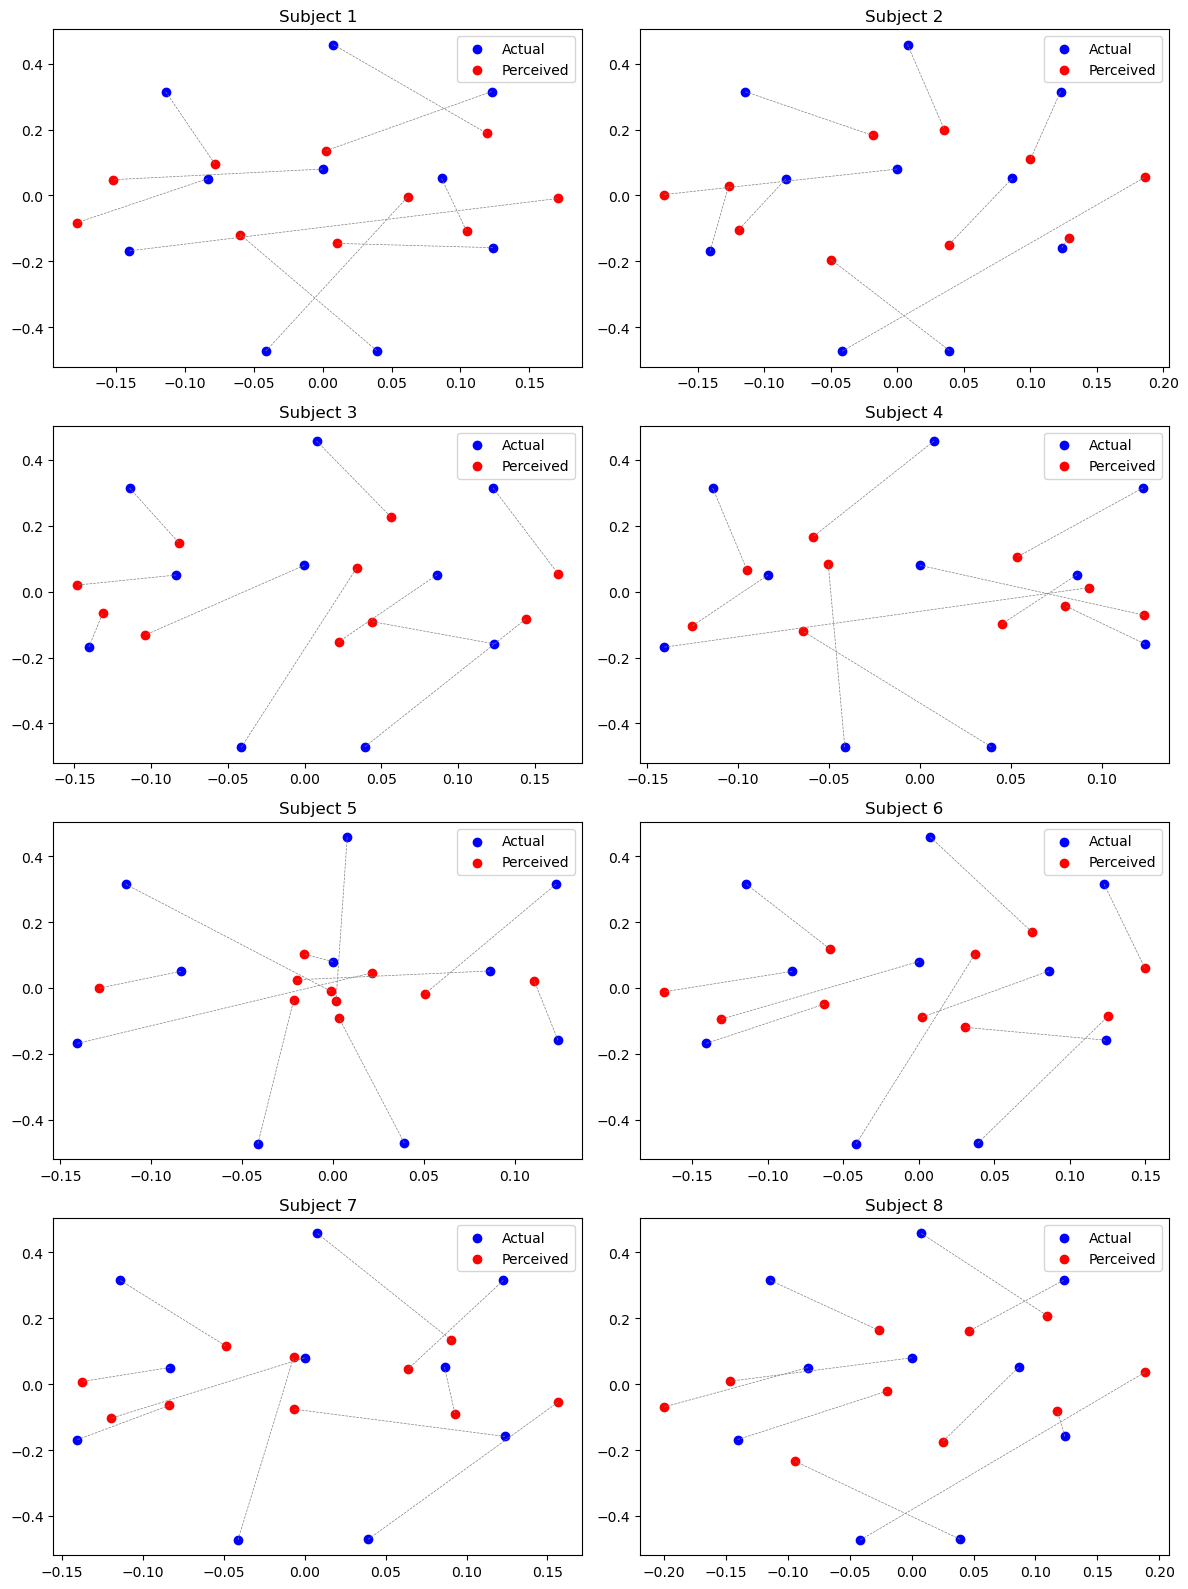

In [25]:
fig, axes = plt.subplots(4, 2, figsize=(12, 16))  # Create a 4x2 grid of subplots
for i, (subject, (actual, perceived, _)) in enumerate(procrustes_results.items()):
    ax = axes.flatten()[i]  # Flatten the grid to easily access subplots
    ax.scatter(actual[:, 0], actual[:, 1], color='blue', label='Actual')  # Plot actual coordinates in blue
    ax.scatter(perceived[:, 0], perceived[:, 1], color='red', label='Perceived')  # Plot perceived coordinates in red
    for (x_actual, y_actual), (x_perceived, y_perceived) in zip(actual, perceived):
        ax.plot([x_actual, x_perceived], [y_actual, y_perceived], color='gray', linestyle='--', linewidth=0.5)  # Draw connecting lines
    ax.legend()  # Add legend
    ax.set_title(f'Subject {i+1}')  # Set title for each subplot
plt.tight_layout()  # Adjust subplots to fit in the figure area
plt.show()  # Display the plot

Function to perform generalized Procrustes analysis with scaling

In [13]:
def generalized_procrustes_analysis(shapes):
    shapes_centered = [shape - shape.mean(axis=0) for shape in shapes]  # Center each shape by subtracting the mean
    shapes_normalized = [shape / np.linalg.norm(shape) for shape in shapes_centered]  # Normalize each shape
    mean_shape = np.mean(shapes_normalized, axis=0)  # Calculate the initial mean shape
    for _ in range(10):  # Perform 10 iterations for alignment
        aligned_shapes = [shape @ orthogonal_procrustes(mean_shape, shape)[0] for shape in shapes_normalized]  # Align shapes
        new_mean_shape = np.mean(aligned_shapes, axis=0)  # Calculate new mean shape
        if np.allclose(mean_shape, new_mean_shape, atol=1e-6):  # Check for convergence
            break
        mean_shape = new_mean_shape  # Update mean shape
    return mean_shape, aligned_shapes  # Return mean shape and aligned shapes

Function to align perceived shape to the actual shape using Procrustes analysis

In [14]:
def align_shapes(target_shape, source_shape):
    matrix, _ = orthogonal_procrustes(target_shape, source_shape)
    return source_shape @ matrix

Prepare the shapes for GPA and perform GPA

In [15]:
actual_shapes = list(actual_coords.values())  # Collect actual shapes
perceived_shapes = list(raw_coords.values())  # Collect perceived shapes

Perform GPA for 2D shapes

In [16]:
mean_actual_shape, aligned_actual_shapes = generalized_procrustes_analysis(actual_shapes)
mean_perceived_shape, aligned_perceived_shapes = generalized_procrustes_analysis(perceived_shapes)
aligned_mean_perceived_shape = align_shapes(mean_actual_shape, mean_perceived_shape)

Visualize the mean shapes

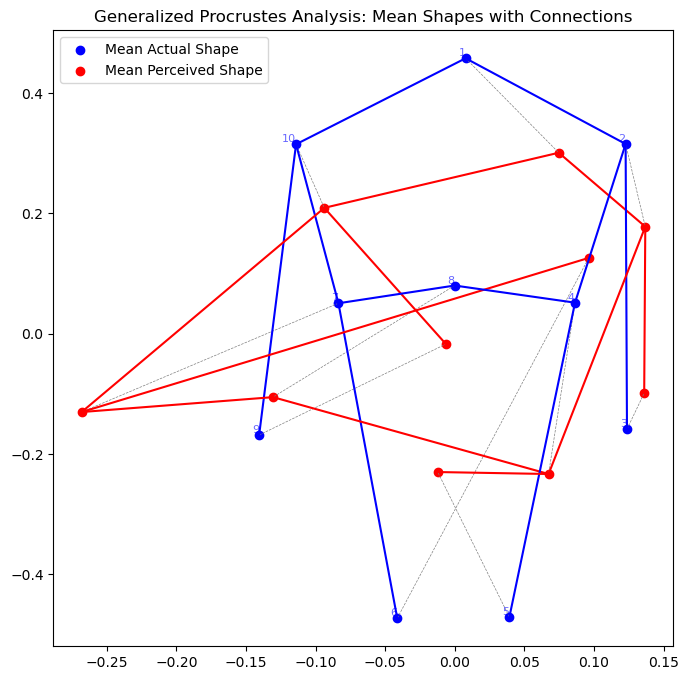

In [17]:
plt.figure(figsize=(8, 8))
plt.scatter(mean_actual_shape[:, 0], mean_actual_shape[:, 1], color='blue', label='Mean Actual Shape')
plt.scatter(aligned_mean_perceived_shape[:, 0], aligned_mean_perceived_shape[:, 1], color='red', label='Mean Perceived Shape')
for (x_actual, y_actual), (x_perceived, y_perceived) in zip(mean_actual_shape, aligned_mean_perceived_shape):
    plt.plot([x_actual, x_perceived], [y_actual, y_perceived], color='gray', linestyle='--', linewidth=0.5)
connections = [(0, 9), (9, 8), (9, 6), (6, 5), (6, 7), (7, 3), (3, 4), (0, 1), (1, 2), (3, 1)]
for start, end in connections:
    plt.plot([mean_actual_shape[start, 0], mean_actual_shape[end, 0]], [mean_actual_shape[start, 1], mean_actual_shape[end, 1]], color='blue')
    plt.plot([aligned_mean_perceived_shape[start, 0], aligned_mean_perceived_shape[end, 0]], [aligned_mean_perceived_shape[start, 1], aligned_mean_perceived_shape[end, 1]], color='red')
for idx, (x, y) in enumerate(mean_actual_shape):
    plt.text(x, y, str(idx + 1), color='blue', fontsize=8, ha='right', va='bottom', alpha=0.6)
plt.legend()
plt.title('Generalized Procrustes Analysis: Mean Shapes with Connections')
plt.show()

Function to perform MDS and return eigenvalues

In [18]:
def mds_eigenvalues(squareform_matrix, n_components=10):
    mds = MDS(dissimilarity='precomputed', n_components=n_components, random_state=0)
    coords = mds.fit_transform(squareform_matrix)
    stress = mds.stress_
    eigenvalues = stress / (np.arange(1, n_components + 1) ** 2)
    return eigenvalues

Extract raw data for each subject and calculate eigenvalues

In [19]:
eigenvalues_all_subjects = np.array([mds_eigenvalues(raw_to_squareform(raw_data.iloc[:, i].values)) for i in range(num_subjects)])
avg_eigenvalues = np.mean(eigenvalues_all_subjects, axis=0)
sem_eigenvalues = np.std(eigenvalues_all_subjects, axis=0, ddof=1) / np.sqrt(num_subjects)
variance_explained = (avg_eigenvalues / np.sum(avg_eigenvalues)) * 100
sem_variance_explained = (sem_eigenvalues / np.sum(avg_eigenvalues)) * 100

Plot the scree plot with error bars

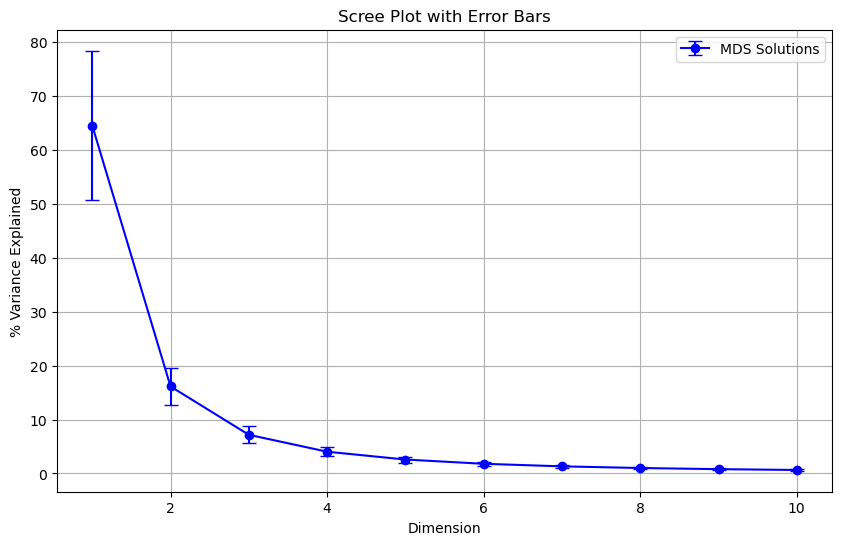

In [20]:
plt.figure(figsize=(10, 6))
plt.errorbar(range(1, len(variance_explained) + 1), variance_explained, yerr=sem_variance_explained, fmt='o-', color='b', label='MDS Solutions', capsize=5)
plt.xlabel('Dimension')
plt.ylabel('% Variance Explained')
plt.title('Scree Plot with Error Bars')
plt.legend()
plt.grid(True)
plt.show()

# 3D Visualisation 
(sanity check)

In [27]:
import pandas as pd  # Importing pandas for data manipulation
import numpy as np  # Importing numpy for numerical operations
from scipy.spatial.distance import squareform  # Importing squareform to convert distance vectors to matrices
from sklearn.manifold import MDS  # Importing MDS for multidimensional scaling
from scipy.spatial import procrustes  # Importing procrustes for shape alignment
from scipy.linalg import orthogonal_procrustes  # Importing orthogonal_procrustes for Procrustes analysis
import plotly.graph_objects as go  # Importing plotly for interactive 3D plots

Path to the Excel file

In [28]:
file_path = '/Users/olga_golubova/Desktop/new data.xlsx'
num_subjects = 8  # Number of subjects

Reading the data from Excel

In [29]:
raw_data = pd.read_excel(file_path, sheet_name='raw data', header=None)  # Raw data
actual_data = pd.read_excel(file_path, sheet_name='actual', header=None)  # Actual coordinates data

Extracting x, y, z coordinates for each subject and storing them in a dictionary. Dimension Z has zeros in actual data 

In [30]:
actual_coords_3d = {
    f'subject_{i+1}': np.column_stack((actual_data.iloc[:10, i].values, actual_data.iloc[10:20, i].values, np.zeros(10))) 
    for i in range(num_subjects)
}

Function to convert raw data to squareform matrix

In [31]:
def raw_to_squareform(raw_column):
    return squareform(raw_column)

Function to perform multidimensional scaling

In [32]:
def mds_coordinates_3d(squareform_matrix):
    mds = MDS(dissimilarity='precomputed', n_components=3, random_state=0)
    return mds.fit_transform(squareform_matrix)

Extract raw data, perform MDS and prepare for Procrustes alignment

In [33]:
perceived_coords_3d = {
    f'subject_{i+1}': mds_coordinates_3d(raw_to_squareform(raw_data.iloc[:, i].values)) 
    for i in range(num_subjects)
}

Function to perform generalized Procrustes analysis with scaling

In [34]:
def generalized_procrustes_analysis(shapes):
    shapes_centered = [shape - shape.mean(axis=0) for shape in shapes]  # Center each shape by subtracting the mean
    shapes_normalized = [shape / np.linalg.norm(shape) for shape in shapes_centered]  # Normalize each shape
    mean_shape = np.mean(shapes_normalized, axis=0)  # Calculate the initial mean shape
    for _ in range(10):  # Perform 10 iterations for alignment
        aligned_shapes = [shape @ orthogonal_procrustes(mean_shape, shape)[0] for shape in shapes_normalized]  # Align shapes
        new_mean_shape = np.mean(aligned_shapes, axis=0)  # Calculate new mean shape
        if np.allclose(mean_shape, new_mean_shape, atol=1e-6):  # Check for convergence
            break
        mean_shape = new_mean_shape  # Update mean shape
    return mean_shape, aligned_shapes  # Return mean shape and aligned shapes

Function to align perceived shape to the actual shape using Procrustes analysis

In [35]:
def align_shapes(target_shape, source_shape):
    matrix, _ = orthogonal_procrustes(target_shape, source_shape)
    return source_shape @ matrix

Perform GPA for 3D shapes

In [36]:
mean_actual_shape_3d, _ = generalized_procrustes_analysis(list(actual_coords_3d.values()))
mean_perceived_shape_3d, _ = generalized_procrustes_analysis(list(perceived_coords_3d.values()))
aligned_mean_perceived_shape_3d = align_shapes(mean_actual_shape_3d, mean_perceived_shape_3d)

Create a 3D scatter plot using Plotly

In [38]:
fig = go.Figure()

Add mean actual shape points

In [39]:
fig.add_trace(go.Scatter3d(
    x=mean_actual_shape_3d[:, 0], y=mean_actual_shape_3d[:, 1], z=mean_actual_shape_3d[:, 2], 
    mode='markers+text', marker=dict(color='blue', size=5), text=[str(i+1) for i in range(mean_actual_shape_3d.shape[0])], 
    textposition='top center', name='Mean Actual Shape'))

Add mean perceived shape points

In [40]:
fig.add_trace(go.Scatter3d(
    x=aligned_mean_perceived_shape_3d[:, 0], y=aligned_mean_perceived_shape_3d[:, 1], z=aligned_mean_perceived_shape_3d[:, 2], 
    mode='markers+text', marker=dict(color='red', size=5), text=[str(i+1) for i in range(aligned_mean_perceived_shape_3d.shape[0])], 
    textposition='top center', name='Mean Perceived Shape'))

Add lines connecting corresponding points

In [41]:
for (x_actual, y_actual, z_actual), (x_perceived, y_perceived, z_perceived) in zip(mean_actual_shape_3d, aligned_mean_perceived_shape_3d):
    fig.add_trace(go.Scatter3d(
        x=[x_actual, x_perceived], y=[y_actual, y_perceived], z=[z_actual, z_perceived], mode='lines', 
        line=dict(color='gray', width=1, dash='dash'), showlegend=False))

Add lines connecting specific points for easier interpretation

*(Points:
0 - Head;
1 - R shoulder;
2 - R hand;
3 - R hip;
4 - R foot;
5 - L foot;
6 - L hip;
7 - Navel;
8 - L hand;
9 - L shoulder)*


In [42]:
connections = [(0, 9), (9, 8), (9, 6), (6, 5), (6, 7), (7, 3), (3, 4), (0, 1), (1, 2), (3, 1)]
for start, end in connections:
    fig.add_trace(go.Scatter3d(
        x=[mean_actual_shape_3d[start, 0], mean_actual_shape_3d[end, 0]], 
        y=[mean_actual_shape_3d[start, 1], mean_actual_shape_3d[end, 1]], 
        z=[mean_actual_shape_3d[start, 2], mean_actual_shape_3d[end, 2]], 
        mode='lines', line=dict(color='blue', width=2), showlegend=False))
    fig.add_trace(go.Scatter3d(
        x=[aligned_mean_perceived_shape_3d[start, 0], aligned_mean_perceived_shape_3d[end, 0]], 
        y=[aligned_mean_perceived_shape_3d[start, 1], aligned_mean_perceived_shape_3d[end, 1]], 
        z=[aligned_mean_perceived_shape_3d[start, 2], aligned_mean_perceived_shape_3d[end, 2]], 
        mode='lines', line=dict(color='red', width=2), showlegend=False))

Set plot layout

In [43]:
fig.update_layout(title='Generalized Procrustes Analysis: Mean Shapes with Connections', 
                  scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))
fig.show()